In [1]:
import pandas as pd
import numpy as np
#-----------------------------------------Scikit----------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder

#------------------------------------import feature selection----------------------------------
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2            #score_func, need to normalize to remove negative to use
from sklearn.feature_selection import f_classif
#-----------------------------------------Seaborn----------------------------------------------
import matplotlib.pyplot as plt
import ssl
import seaborn as sns
ssl._create_default_https_context = ssl._create_unverified_context
sns.set(style='darkgrid')

In [2]:
df = pd.read_csv('./Data/features_30_sec.csv')    #read file

In [3]:
df.head()                                        #display first 5 rows of data

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
df = df.drop(['length','filename'],axis=1)             #remove the length and filename column since irrelevant
df = df.sample(frac=1)                                 #randomize rows of dataset every run
df

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
16,0.304186,0.098493,0.081472,0.002641,1454.963941,152317.123532,1825.797960,116774.735699,3009.460817,1.010620e+06,...,77.966492,-4.456850,82.935326,0.009554,85.942924,1.293031,83.567490,-2.098081,100.874100,blues
169,0.236636,0.085286,0.029150,0.000149,1349.275014,41423.261672,1522.806819,34731.726115,2443.460657,1.595205e+05,...,159.224823,7.834348,185.680496,4.321858,109.217422,2.988080,106.869637,5.856627,104.321083,classical
565,0.247623,0.090184,0.082273,0.001597,1337.475442,143478.937879,1518.245531,32911.413802,2754.218252,7.021286e+05,...,94.843094,-0.058282,94.394012,-1.626525,93.433403,3.260668,75.741127,-1.309226,91.235840,jazz
369,0.389193,0.082729,0.111631,0.001731,1931.082069,188567.674409,2209.150997,43228.108244,4516.110562,7.097685e+05,...,29.582720,-7.945790,28.254889,3.666682,34.077782,-6.156417,35.428486,2.696897,33.346764,disco
285,0.337893,0.087253,0.135495,0.001885,1596.307516,278627.017046,1853.316211,101805.705363,3291.440860,1.181595e+06,...,66.668198,-8.047359,75.022209,2.645392,53.849991,-1.852184,54.705471,-3.417413,77.737061,country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,0.329137,0.090313,0.094154,0.001773,2133.200382,276253.439506,2289.540104,130964.269614,4801.329745,1.912257e+06,...,67.178230,-9.199856,89.098007,3.286665,75.316483,-0.759790,86.541344,3.761663,104.204071,reggae
125,0.297426,0.084191,0.064101,0.000519,1184.132550,54219.957458,1304.705302,32217.827057,2139.247956,2.023403e+05,...,41.899982,0.226399,35.420792,-0.972557,48.129139,-0.492806,49.615078,-6.258420,69.617943,classical
279,0.310331,0.085127,0.115341,0.001594,963.490560,284124.443333,1235.415857,259638.114618,1754.423137,1.656585e+06,...,76.243042,-3.776454,81.260490,-4.801566,64.349510,-4.711809,59.268246,-2.950048,86.477142,country
593,0.269424,0.080304,0.045304,0.000150,2152.894239,239034.377058,2775.494487,137474.163820,5015.995629,2.671570e+06,...,69.596481,2.000226,102.378937,-0.247875,114.516739,0.963551,87.610146,-2.137088,69.771652,jazz


<AxesSubplot:xlabel='chroma_stft_var', ylabel='rolloff_mean'>

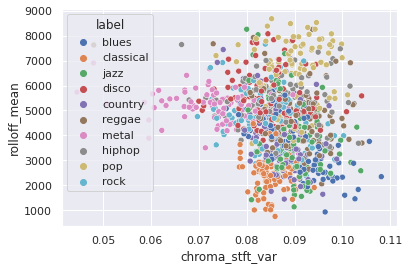

In [5]:
sns.scatterplot(data = df, x ='chroma_stft_var',y='rolloff_mean',hue='label')

In [6]:
#-----------------------------------------Encode The Genre Into Numbers-----------------------------------------
labelEncoder = LabelEncoder()              #store encoded labels into variable
le = labelEncoder.fit(df['label'])                            #fit label into the variable
df['label'] = le.transform(df['label'])        #transform label values into numbers
Y_genre = df['label']
X_features = df.drop('label',axis=1)

In [7]:
X_features.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
16,0.304186,0.098493,0.081472,0.002641,1454.963941,152317.123532,1825.797960,116774.735699,3009.460817,1.010620e+06,...,-3.894501,77.966492,-4.456850,82.935326,0.009554,85.942924,1.293031,83.567490,-2.098081,100.874100
169,0.236636,0.085286,0.029150,0.000149,1349.275014,41423.261672,1522.806819,34731.726115,2443.460657,1.595205e+05,...,10.980692,159.224823,7.834348,185.680496,4.321858,109.217422,2.988080,106.869637,5.856627,104.321083
565,0.247623,0.090184,0.082273,0.001597,1337.475442,143478.937879,1518.245531,32911.413802,2754.218252,7.021286e+05,...,2.568355,94.843094,-0.058282,94.394012,-1.626525,93.433403,3.260668,75.741127,-1.309226,91.235840
369,0.389193,0.082729,0.111631,0.001731,1931.082069,188567.674409,2209.150997,43228.108244,4516.110562,7.097685e+05,...,3.481374,29.582720,-7.945790,28.254889,3.666682,34.077782,-6.156417,35.428486,2.696897,33.346764
285,0.337893,0.087253,0.135495,0.001885,1596.307516,278627.017046,1853.316211,101805.705363,3291.440860,1.181595e+06,...,5.114319,66.668198,-8.047359,75.022209,2.645392,53.849991,-1.852184,54.705471,-3.417413,77.737061


In [8]:
Y_genre.tail()

800    8
125    1
279    2
593    5
519    5
Name: label, dtype: int64

<AxesSubplot:xlabel='chroma_stft_var', ylabel='rolloff_mean'>

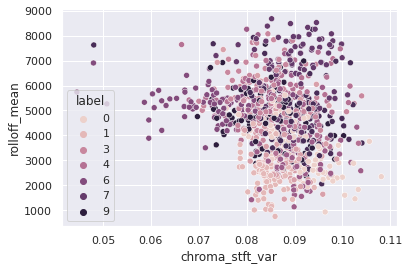

In [9]:
#------------------------------Scatterplot of Data--------------------------------------------------
sns.scatterplot(data = df, x ='chroma_stft_var',y='rolloff_mean',hue='label')

In [10]:
df[df['label'] == 2]

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
285,0.337893,0.087253,0.135495,0.001885,1596.307516,278627.017046,1853.316211,101805.705363,3291.440860,1.181595e+06,...,66.668198,-8.047359,75.022209,2.645392,53.849991,-1.852184,54.705471,-3.417413,77.737061,2
288,0.353736,0.083778,0.152685,0.002718,1622.736351,234048.997259,1963.356614,129809.058857,3526.990454,1.474988e+06,...,74.533981,-5.457431,75.096725,4.972629,46.626919,-3.045774,68.116638,-3.315417,49.769081,2
244,0.360101,0.085341,0.113700,0.001413,1729.627760,561523.765316,2247.426190,303943.729721,3358.804980,2.989752e+06,...,57.065800,-3.467204,84.143745,-2.559405,65.260384,5.665481,75.914841,-3.635042,72.006874,2
201,0.414032,0.079332,0.230516,0.000446,2938.155358,101837.490524,2839.657689,40987.078803,6279.551665,6.262134e+05,...,37.167381,-2.764677,46.065048,2.824268,48.752991,-1.738780,44.390938,0.974067,48.062492,2
241,0.397855,0.082284,0.113301,0.000587,2634.080774,820747.026509,2898.541576,233608.971679,5807.827964,4.557787e+06,...,42.996780,-2.325614,41.673706,-4.613111,41.339603,-0.618727,29.171967,-4.939899,29.804676,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,0.429653,0.073870,0.236554,0.001334,3191.197463,177597.267355,2948.001830,68534.157767,6926.704746,8.651962e+05,...,42.860069,-1.169091,34.326366,4.573297,28.203312,0.887555,36.261787,1.296124,35.709606,2
215,0.379448,0.079580,0.104801,0.000668,1958.677390,356482.601840,2146.416728,103469.666282,4207.726116,1.555988e+06,...,27.552799,-5.475275,27.640854,-2.956244,26.237810,-2.640563,33.477554,-3.385912,40.309345,2
266,0.320641,0.080941,0.136513,0.001457,1701.919072,109321.966926,1709.530314,60604.296880,3244.627377,6.017692e+05,...,61.911690,-2.066858,50.994350,3.285207,55.881519,0.275862,43.114582,-4.217203,39.091068,2
207,0.421538,0.082282,0.244199,0.000641,2898.717713,377421.441623,2878.981441,95177.861882,6399.852968,1.408450e+06,...,44.953568,-2.807132,45.408470,2.976282,46.172512,-1.835009,61.663452,-2.365688,62.474205,2


In [11]:
best_feat = SelectKBest(score_func= f_classif, k=10)
fit = best_feat.fit(X_features,Y_genre)

In [12]:
feat_scores = pd.DataFrame(fit.scores_)
feat_columns = pd.DataFrame(X_features.columns)

In [13]:
sel_scores = pd.concat([feat_columns,feat_scores],axis=1)
sel_scores.columns = ['Features','Scores']

In [14]:
sel_scores.sort_values(by=['Scores'],ascending=False)
sel_largest = sel_scores.nlargest(10,'Scores')
sel_largest

,Features,Scores
0,chroma_stft_mean,176.453282
17,mfcc1_mean,130.371835
6,spectral_bandwidth_mean,116.601879
8,rolloff_mean,110.871317
4,spectral_centroid_mean,97.484924
23,mfcc4_mean,83.868555
19,mfcc2_mean,83.189909
5,spectral_centroid_var,82.134648
15,perceptr_var,80.388712
2,rms_mean,74.194652


In [15]:
X_features = X_features[sel_largest['Features'].T]
X_features

,chroma_stft_mean,mfcc1_mean,spectral_bandwidth_mean,rolloff_mean,spectral_centroid_mean,mfcc4_mean,mfcc2_mean,spectral_centroid_var,perceptr_var,rms_mean
16,0.304186,-233.759094,1825.797960,3009.460817,1454.963941,39.518478,120.675140,152317.123532,0.002415,0.081472
169,0.236636,-321.263458,1522.806819,2443.460657,1349.275014,31.039000,136.308533,41423.261672,0.000008,0.029150
565,0.247623,-235.768005,1518.245531,2754.218252,1337.475442,62.568584,144.792999,143478.937879,0.000946,0.082273
369,0.389193,-118.356224,2209.150997,4516.110562,1931.082069,37.388794,114.232620,188567.674409,0.004058,0.111631
285,0.337893,-145.995270,1853.316211,3291.440860,1596.307516,49.247871,124.626671,278627.017046,0.002668,0.135495
...,...,...,...,...,...,...,...,...,...,...
800,0.329137,-159.454605,2289.540104,4801.329745,2133.200382,34.656593,104.858856,276253.439506,0.002510,0.094154
125,0.297426,-221.280136,1304.705302,2139.247956,1184.132550,24.363493,173.329514,54219.957458,0.000354,0.064101
279,0.310331,-229.038071,1235.415857,1754.423137,963.490560,24.161379,180.356339,284124.443333,0.001201,0.115341
593,0.269424,-215.344070,2775.494487,5015.995629,2152.894239,12.981798,100.933151,239034.377058,0.000165,0.045304


<AxesSubplot:xlabel='chroma_stft_mean', ylabel='mfcc1_mean'>

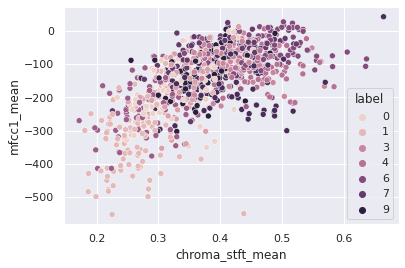

In [16]:
sns.scatterplot(data = pd.concat([X_features,Y_genre],axis=1), x ='chroma_stft_mean',y='mfcc1_mean',hue='label')

In [17]:
#-------------------------------------Split data into train and test----------------------------------------
#X_train,X_test,y_train,y_test = train_test_split(X_features,Y_genre,test_size=0.25)

In [18]:
# #----------------------------Use ML to reduce # of data columns---------------------------------------------
# pca = PCA(n_components=20)                            #reduce to 30 columns
# pca.fit(X_features)                                   #fit data into the pca
# train_data_pca = pca.transform(train_data)
# test_data_pca = pca.transform(test_data)

In [19]:
#----------------------------------------------K Nearest Neighbor------------------------------------------------
# knn = KNeighborsClassifier(n_neighbors=8)
# knn.fit(train_data_pca,train_label.values.ravel())
# pred = knn.predict(test_data_pca)

In [20]:
df = df.sample(frac=1)                                #randomize rows of dataset
row,col = pd.concat([X_features,Y_genre],axis=1).shape  #extract size of dataset
split = 0.75                                          #3/4 training split
X_train = df.iloc[:int(row*split),:-1]             #obtain 75% of test data
y_train = df.iloc[:int(row*split),-1:]            #obtain 75% of genre data
X_test = df.iloc[int(row*split):,:-1]              #obtain 25% of test data
y_test = df.iloc[int(row*split):,-1:]             #obtain 25% of genre data

In [21]:
clf = RandomForestClassifier(n_estimators=50, max_depth=None,min_samples_split=2,random_state=0)
clf.fit(X_train,y_train.values.ravel())

RandomForestClassifier(n_estimators=50, random_state=0)

In [22]:
clf.predict(X_test)

array([8, 5, 1, 6, 3, 5, 6, 1, 1, 5, 3, 3, 4, 6, 6, 3, 1, 4, 6, 3, 3, 6,
       5, 8, 8, 0, 0, 8, 1, 6, 9, 4, 5, 0, 5, 3, 9, 8, 2, 8, 2, 7, 2, 4,
       3, 3, 7, 5, 5, 0, 0, 3, 4, 2, 7, 2, 6, 2, 1, 8, 8, 8, 1, 1, 6, 6,
       5, 3, 4, 9, 9, 1, 0, 9, 4, 1, 6, 2, 3, 8, 3, 8, 7, 3, 4, 1, 9, 7,
       9, 1, 3, 1, 7, 4, 0, 9, 1, 4, 3, 7, 3, 5, 6, 0, 2, 3, 3, 5, 3, 6,
       7, 5, 9, 0, 4, 3, 8, 2, 8, 8, 3, 0, 6, 9, 7, 0, 1, 9, 2, 9, 2, 6,
       4, 3, 5, 7, 1, 7, 2, 6, 0, 0, 5, 2, 5, 0, 9, 0, 7, 6, 5, 7, 1, 6,
       4, 8, 0, 0, 2, 2, 0, 8, 5, 8, 1, 5, 6, 0, 4, 1, 6, 2, 1, 6, 9, 0,
       9, 7, 5, 7, 2, 0, 9, 5, 4, 5, 7, 8, 9, 8, 4, 1, 6, 1, 9, 9, 1, 5,
       6, 2, 1, 2, 2, 9, 8, 8, 8, 4, 3, 6, 0, 3, 8, 5, 6, 3, 3, 3, 3, 7,
       2, 5, 8, 8, 0, 3, 7, 0, 2, 6, 3, 3, 5, 1, 4, 8, 3, 3, 3, 7, 1, 5,
       0, 2, 4, 6, 8, 8, 8, 0])

In [23]:
clf.score(X_test,y_test)

0.704